# XLNet Classification example

In [2]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

import torch

## Define dictionary containing all model and environmental parameters

In [3]:
task_name  = 'xlnet_256' 
params = {
    'data_dir': 'data/',                              # Directory of train.tsv, evaluation.tsv and test.tsv (optional)
    'params_dict_dir' : f'{task_name}_params.json',   # We save the dict here. It will be overwritten with more info. 
    'model_type':  'xlnet',                           # Defines the model type
    'model': 'xlnet-base-cased',                      # Defines the exact model
    'task_name': 'binary',
    'output_dir': f'outputs/{task_name}/',            # The output will be saved in the output/bert_128 directory
    'cache_dir': 'cache/',                            
    'do_train': True,                                 # Need to specify True for training
    'do_eval': False,                                 # Need to specify True for evaluation
    'evaluate_during_training': False,
    'fp16': False,                                    # If True, decrease precision of all calculation (needs apex package)
    'fp16_opt_level': 'O1',                           # Precision level (only relevant if fp16 is defined True)
    'max_seq_len': 256,                               # Max text taken for one sentence
    'output_mode': 'classification',
    'train_batch_size': 16,
    'eval_batch_size': 16,

    'gradient_accumulation_steps': 1,
    'num_train_epochs': 6,
    'weight_decay': 0,
    'learning_rate': 4e-5,
    'adam_epsilon': 1e-8,
    'warmup_ratio': 0.06,
    'warmup_steps': 0,
    'max_grad_norm': 1.0,

    'logging_steps': 50,
    'evaluate_during_training': False,
    'save_steps': 2000,
    'eval_all_checkpoints': True,

    'overwrite_output_dir': False,
    'reprocess_input_data': True,
    'notes': 'Using IMDB dataset',
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

### Add tokenizer to the model

In [4]:
from pytorch_transformers import (WEIGHTS_NAME, BertConfig, BertForSequenceClassification, BertTokenizer,
                                  XLMConfig, XLMForSequenceClassification, XLMTokenizer, 
                                  XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer,
                                  RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer)
MODEL_CLASSES = {
    'bert': (BertConfig, BertForSequenceClassification, BertTokenizer),
    'xlnet': (XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer),
    'xlm': (XLMConfig, XLMForSequenceClassification, XLMTokenizer),
    'roberta': (RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer)
}

config_class, model_class, tokenizer_class = MODEL_CLASSES[params['model_type']]

config = config_class.from_pretrained(params['model'], num_labels=2, finetuning_task=params['task_name'])
tokenizer = tokenizer_class.from_pretrained(params['model'])
params["tokenizer"] = tokenizer

## Creating output and reports dir 

In [5]:
from modules.outils import *

create_reports_directory(params)
create_output_directory(params)

## Process data
### Create features from the data 

In [6]:
from modules.process import create_features

features, params = create_features(params, 'train')
eval_features, params = create_features(params, 'evaluation')
val_features, params = create_features(params, 'evaluation')

Loading features from cached file data/train_features_256_xlnet-base-cased..
Loading is finished from file data/train_features_256_xlnet-base-cased..
Adding train_example_length to the parameters dict and saving it in xlnet_256_params.json
Loading features from cached file data/evaluation_features_256_xlnet-base-cased..
Loading is finished from file data/evaluation_features_256_xlnet-base-cased..
Adding evaluation_example_length to the parameters dict and saving it in xlnet_256_params.json
Loading features from cached file data/evaluation_features_256_xlnet-base-cased..
Loading is finished from file data/evaluation_features_256_xlnet-base-cased..
Adding evaluation_example_length to the parameters dict and saving it in xlnet_256_params.json


### Create dataloaders

In [7]:
from modules.process import create_dataloader

# Create dataloader for train data
dataloader = create_dataloader(features, params, evaluation=False)
dataloader_name = f'{params["data_dir"]}dataloader_{params["max_seq_len"]}_{params["model"]}'
torch.save(dataloader, dataloader_name)

# Create dataloader for eval data
eval_dataloader, all_label_ids = create_dataloader(eval_features, params, evaluation=True)
eval_dataloader_name = f'{params["data_dir"]}eval_dataloader_{params["max_seq_len"]}_{params["model"]}'
torch.save(eval_dataloader, eval_dataloader_name)
torch.save(all_label_ids, f'{params["data_dir"]}eval_label_ids')
           
# Create dataloader for eval data
val_dataloader, all_label_ids = create_dataloader(val_features, params, evaluation=True)
val_dataloader_name = f'{params["data_dir"]}val_dataloader_{params["max_seq_len"]}_{params["model"]}'
torch.save(val_dataloader, val_dataloader_name)
torch.save(all_label_ids, f'{params["data_dir"]}eval_label_ids')

## Load model

In [8]:
model = model_class.from_pretrained(params['model'])
model.to(params["device"])

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

# Training
Here I run training without evaluation. 
If wish to evaluate during training, define a third data, 'val_data.tsv', process it the same way as evaluation (create_dataloader) and pass it as eval_dataloader argument into the 'train' function. 

I did not evaluate during training as training was long enough even without evaluation. 

In [9]:
from modules.model_functions import train

if params['do_train'] and params['evaluate_during_training']: 
    model, train_loss_set, global_step, tr_loss = train(dataloader, model, params, val_dataloader)
elif params['do_train']:
    model, train_loss_set, global_step, tr_loss = train(dataloader, model, params, None)

INFO:modules.model_functions:***** Running training *****
INFO:modules.model_functions:  Num examples = 25000
INFO:modules.model_functions:  Num Epochs = 6
INFO:modules.model_functions:  Total train batch size  = 16
INFO:modules.model_functions:  Gradient Accumulation steps = 1
INFO:modules.model_functions:  Total optimization steps = 150000
Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

0.011598

Epoch:  17%|█▋        | 1/6 [14:46<1:13:52, 886.46s/it]

0.049648

INFO:modules.model_functions:Saving model checkpoint to outputs/xlnet_256/checkpoint-2000


0.290103

Epoch:  33%|███▎      | 2/6 [29:29<59:01, 885.29s/it]  

0.352248

INFO:modules.model_functions:Saving model checkpoint to outputs/xlnet_256/checkpoint-4000


0.050736

Epoch:  50%|█████     | 3/6 [44:11<44:13, 884.40s/it]

0.008773

INFO:modules.model_functions:Saving model checkpoint to outputs/xlnet_256/checkpoint-6000


0.020276

Epoch:  67%|██████▋   | 4/6 [58:52<29:27, 883.51s/it]

0.001606

Epoch:  83%|████████▎ | 5/6 [1:13:34<14:42, 882.94s/it]

0.008622

INFO:modules.model_functions:Saving model checkpoint to outputs/xlnet_256/checkpoint-8000


0.016374

Epoch: 100%|██████████| 6/6 [1:28:15<00:00, 882.52s/it]

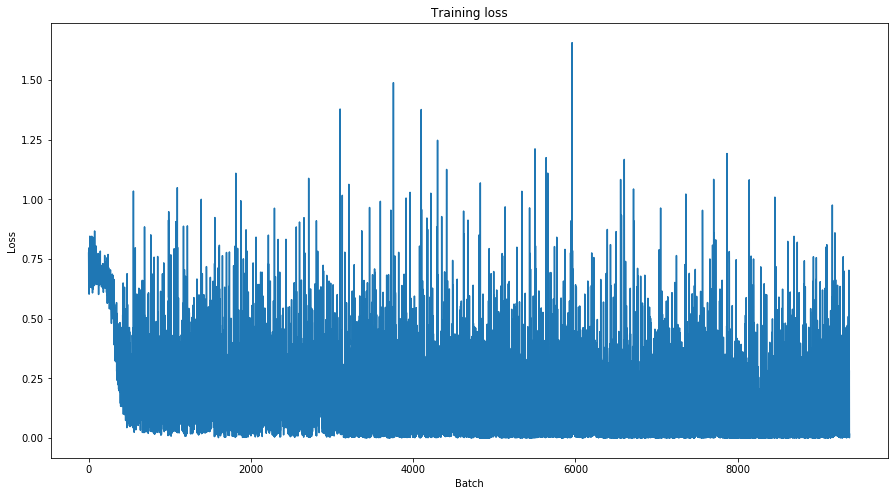

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [12]:
import os 

if "weights_name" not in params:
    params["weights_name"] = "pytorch_model.bin"
if "config_name" not in params:
    params["config_name"] = "config.json"

output_model_file = os.path.join(params["output_dir"], params["weights_name"])
output_config_file = os.path.join(params["output_dir"], params["config_name"])
print(f'Save model, config and vocab to {params["output_dir"]}..')
torch.save(model.state_dict(), output_model_file)
model.config.to_json_file(output_config_file)
tokenizer.save_vocabulary(params["output_dir"])
print(f'Model, config and vocab are saved in {params["output_dir"]}..')

Save model, config and vocab to outputs/xlnet_256/..
Model, config and vocab are saved in outputs/xlnet_256/..


# Evaluation

In [13]:
from modules.model_functions import evaluate

result = evaluate(model, eval_dataloader, params, prefix="")

INFO:modules.model_functions:***** Eval results  *****
INFO:modules.model_functions:  accuracy = 0.92672
INFO:modules.model_functions:  eval_loss = 0.3110876701514803
INFO:modules.model_functions:  f1-score = 0.926496549510512
INFO:modules.model_functions:  fn = 954
INFO:modules.model_functions:  fp = 878
INFO:modules.model_functions:  logloss = 2.438569324760437
INFO:modules.model_functions:  mcc = 0.8534557747395609
INFO:modules.model_functions:  model = xlnet-base-cased
INFO:modules.model_functions:  precision = 0.9293303283966516
INFO:modules.model_functions:  recall = 0.92368
INFO:modules.model_functions:  task_name = binary
INFO:modules.model_functions:  tn = 11622
INFO:modules.model_functions:  tp = 11546
